In [1]:
import numpy as np

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784',version=1)
mnist.keys()
X,y = mnist['data'], mnist['target']

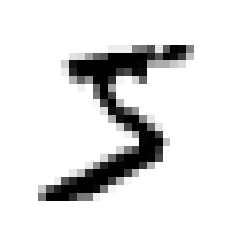

In [3]:
import matplotlib as mlt
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)


plt.imshow(some_digit_image,cmap='binary')
plt.axis('off')
plt.show()

In [4]:
y[0]

'5'

In [5]:
#将y转成整数
y = y.astype(np.uint8)

In [6]:
#mnist 以及将数据机分成了训练集与测试集
X_train,X_test, y_train, y_test = X[:60000], X[60000:] ,y[:60000], y[60000:]


In [7]:
#训练一个简单的二元分类问题
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

#使用随机梯度下降分类器
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)


SGDClassifier(random_state=42)

In [8]:
sgd_clf.predict([some_digit])

array([ True])

In [9]:
#性能测量
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3,random_state=42)

for train_index ,test_index in skfolds.split(X_train,y_train_5):
    clone_clf = clone(sgd_clf)
    x_train_fold = X_train[train_index]
    y_train_fold = y_train_5[train_index]

    x_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    clone_clf.fit(x_train_fold,y_train_fold)
    y_pred = clone_clf.predict(x_test_fold)
    n_correct = sum(y_test_fold == y_pred)
    print( n_correct/len(y_pred))
#或者使用cross_val_score,效果相同
# from sklearn.model_selection import cross_val_score
# cross_val_score(sgd_clf,X_train,y_train_5,cv=3,scoring='accuracy')

0.95035
0.96035
0.9604


In [10]:
#正确率都超过了95%，能否说明分类效果很好；
#创建一个全部预测为False的分类器，看看效果；
#可以发现准确率仍然有90%

from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self,X,y=None):
        return self;
    def predict(self,X):
        return np.zeros((len(X),1),dtype= bool)

never5Classifier = Never5Classifier();
from sklearn.model_selection import cross_val_score
cross_val_score(never5Classifier,X_train,y_train_5,cv=3,scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

In [11]:
#混淆举证
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf,X_train, y_train_5,cv=3)
#计算混淆举证，需要一组预测与实际目标进行比较


In [12]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5,y_train_pred)



array([[53892,   687],
       [ 1891,  3530]])

In [13]:
#TN FP
#FN TP
#一个完美的分类器，将只有TN与TP；
confusion_matrix(y_train_5,y_train_5)

array([[54579,     0],
       [    0,  5421]])

In [14]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [15]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [16]:
# 精度为所有正类预测的准确率
# 可以发现精度和召回率都是不是那么好；
# 可以将精度和召回率合并为一个指标，这就是F1分数；
# F1分数是精度和召回率的谐波平均值，谐波平均值对较低的值具有更高的权重，所以只有当两个参数都很高时才能获得较高的分数；
from sklearn.metrics import f1_score
f1_score(y_train_5,y_train_pred)

0.7325171197343846

In [19]:
# 遗憾的是鱼与熊掌不可兼得；
# 精度/召回率权衡
# 通过decision_function获得决策分数，在用一个阈值去调整
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [20]:
threshold = 0
some_digit_pred = [y_scores > threshold]
some_digit_pred

[array([ True])]

In [23]:
y_scores = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3,method='decision_function')
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

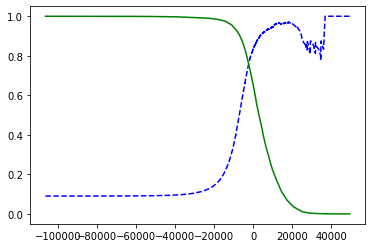

In [25]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1],'b--',label='Precision')
    plt.plot(thresholds, recalls[:-1],'g-',label='Recall')
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()


In [26]:
# 一个90%精度的阈值
threshold_90_precision = thresholds[np.argmax(precisions>=0.9)]
y_train_90_pred = (y_scores >= threshold_90_precision)

In [27]:
precision_score(y_train_5,y_train_90_pred)

0.9000345901072293

In [28]:
recall_score(y_train_5, y_train_90_pred)

0.4799852425751706